# Prerequisites
In order to run the parser you need to install (pip or conda):
* Beautifulsoup4 (XML parser)
* lxml

In [8]:
from tools.ms3 import *
import scipy as sp
logging.getLogger().setLevel(logging.INFO)

In [3]:
data ='data/MuseScore_3'
merged_ids = os.path.join(data, 'merged_ids.tsv')
files = pd.read_csv(merged_ids, sep='\t', index_col=0)
if any(True for file in files.path.values if not os.path.isfile(os.path.join(data, file))):
    print("Not all files found.")
else:
    print("All files found.")
files.loc[files.dance.str.contains('trio'), 'dance'] = 'trio'
files.head()

All files found.


,D,no,dance,path
id,,,,
1,41,1,menuett,041/D041menuett01a.mscx
2,41,1,trio,041/D041trio01b.mscx
3,41,2,menuett,041/D041menuett02a.mscx
4,41,2,trio,041/D041trio02b.mscx
5,41,3,menuett,041/D041menuett03a.mscx


In [4]:
files.groupby('dance').dance.count().plot.bar();

In [9]:
def bag_of_notes(path):
    global S
    S = Score(os.path.join(data,path))
files.path.apply(bag_of_notes)

INFO:root:Attempting to parse D041menuett01a.mscx
INFO:root:Done parsing D041menuett01a.mscx
INFO:root:Attempting to parse D041trio01b.mscx
INFO:root:Done parsing D041trio01b.mscx
INFO:root:Attempting to parse D041menuett02a.mscx
INFO:root:Done parsing D041menuett02a.mscx
INFO:root:Attempting to parse D041trio02b.mscx
INFO:root:Done parsing D041trio02b.mscx
INFO:root:Attempting to parse D041menuett03a.mscx
INFO:root:Done parsing D041menuett03a.mscx
INFO:root:Attempting to parse D041trio03b.mscx
INFO:root:Done parsing D041trio03b.mscx
INFO:root:Attempting to parse D041menuett04a.mscx
INFO:root:Done parsing D041menuett04a.mscx
INFO:root:Attempting to parse D041trio04b.mscx
INFO:root:Done parsing D041trio04b.mscx
INFO:root:Attempting to parse D041menuett05a.mscx
INFO:root:Done parsing D041menuett05a.mscx
INFO:root:Attempting to parse D041trio05b.mscx
INFO:root:Done parsing D041trio05b.mscx
INFO:root:Attempting to parse D041menuett06a.mscx
INFO:root:Done parsing D041menuett06a.mscx
INFO:ro

id
1      None
2      None
3      None
4      None
5      None
       ... 
431    None
432    None
433    None
434    None
435    None
Name: path, Length: 435, dtype: object

In [3]:
S = Score(os.path.join(data,'128/D128deutscher08.mscx'))

INFO:root:Attempting to parse D128deutscher08.mscx
INFO:root:Done parsing D128deutscher08.mscx


[[9]] [26]


In [7]:
S.sections[1].voltas

[[25], [26]]

In [6]:
S.info

,section,keysig,timesig,duration,act_dur,offset,voices,repeats,volta,barline,numbering_offset,dont_count,mn,next
mc,,,,,,,,,,,,,,
0,0,-1,3/4,3/4,3/4,0,3,firstMeasure,NaN,NaN,NaN,NaN,1,[1]
1,0,-1,3/4,3/4,3/4,0,3,NaN,NaN,NaN,NaN,NaN,2,[2]
2,0,-1,3/4,3/4,3/4,0,3,NaN,NaN,NaN,NaN,NaN,3,[3]
3,0,-1,3/4,3/4,3/4,0,3,NaN,NaN,NaN,NaN,NaN,4,[4]
4,0,-1,3/4,3/4,3/4,0,2,NaN,NaN,NaN,NaN,NaN,5,[5]
5,0,-1,3/4,3/4,3/4,0,2,NaN,NaN,NaN,NaN,NaN,6,[6]
6,0,-1,3/4,3/4,3/4,0,2,NaN,NaN,NaN,NaN,NaN,7,[7]
7,0,-1,3/4,3/4,3/4,0,2,endRepeat,NaN,NaN,NaN,NaN,8,"[8, 0]"
8,1,-1,3/4,3/4,3/4,0,2,startRepeat,NaN,NaN,NaN,NaN,9,[9]


In [8]:
S.info

AttributeError: 'NoneType' object has no attribute 'info'

In [4]:
def notes_bag(n):
    """Returns the relative duration of each tonal pitch class in the nth dance"""
    
    note_bag = pd.DataFrame()
    for i in Score(DANCES.File[n]).section_order:
        note_bag = pd.concat([note_bag, Score(DANCES.File[n]).get_notes(pitch_names = True).loc[i]], ignore_index = True)
    
    notes = pd.DataFrame(columns = ['duration'], index = ['C', 'C#', 'C##', 'Dbb', 'Db', 'D', 'D#', 'D##','Ebb', 'Eb', 'E','E#','E##', 'Fbb', 'Fb','F', 'F#','F##','Gbb', 'Gb', 'G', 'G#','G##', 'Abb', 'Ab', 'A', 'A#', 'A##', 'Bbb', 'Bb', 'B', 'B#','B##', 'Cbb','Cb'])

    temp = pd.DataFrame(note_bag.groupby('pitch_names')['duration'].sum()/note_bag.duration.sum())
    
    for note in temp.index:
        notes.loc[note] = temp.loc[note]
    
    #notes.columns = ['tonal_duration']
    
    #return temp.index
    return notes.applymap(float)

In [76]:
temp = []
for dance in DANCES.index:
    if dance in failed_parse:
        temp += [np.nan]
    else:
        notes = notes_bag(dance)
        temp += [float(sp.stats.entropy(notes.dropna())/np.log(35))]
    
DANCES['entropy'] = temp

In [77]:
DANCES.head(10)

,File,Type,entropy
0,data/MuseScore_3/041/D041menuett01a.mscx,menuett,NaN
1,data/MuseScore_3/041/D041menuett02a.mscx,menuett,NaN
2,data/MuseScore_3/041/D041menuett03a.mscx,menuett,NaN
3,data/MuseScore_3/041/D041menuett04a.mscx,menuett,NaN
4,data/MuseScore_3/041/D041menuett05a.mscx,menuett,NaN
5,data/MuseScore_3/041/D041menuett06a.mscx,menuett,NaN
6,data/MuseScore_3/041/D041menuett07a.mscx,menuett,NaN
7,data/MuseScore_3/041/D041menuett08a.mscx,menuett,NaN
8,data/MuseScore_3/041/D041menuett09a.mscx,menuett,NaN
9,data/MuseScore_3/041/D041menuett10a.mscx,menuett,NaN


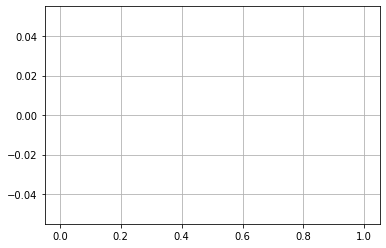

In [78]:
DANCES.entropy.hist();

In [79]:
DANCES.groupby('Type').entropy.mean()

Type
cotillon            NaN
deutscher           NaN
ecossaise           NaN
galopp              NaN
introduzione.mscx   NaN
ländler            NaN
menuett             NaN
trio                NaN
walzer              NaN
Name: entropy, dtype: float64

In [80]:
def keysig(n):
    return Score(DANCES.File[n]).mc_info[0].keysig[0]

In [81]:
temp = []
for i in DANCES.index:
    if i in failed_parse:
        temp += [np.nan]
    else:
        temp += [keysig(i)]

DANCES['Keysig'] = temp

In [82]:
sp.stats.pearsonr(DANCES.dropna().entropy, DANCES.dropna().Keysig )

NameError: name 'scipy' is not defined

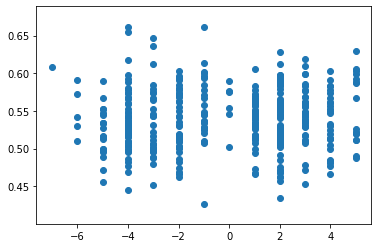

In [108]:
plt.scatter(DANCES.dropna().Keysig, DANCES.dropna().entropy);

In [ ]:
def KK(mode, transposition):
    """Krumhansl and Kessler (1982) key profiles for major and minor modes"""
    
    major = [6.20, 2.55, 3.45, 2.85, 4.22, 4.57, 2.67, 5.25, 2.45, 3.35, 2.70, 2.70]
    minor = [6.03, 3.35, 3.67, 5.28, 2.58, 3.55, 2.87, 4.80, 4.35, 2.67, 2.50, 3.42]
    
    #major = list(map(lambda x: x/sum(major), major))
    #minor = list(map(lambda x: x/sum(minor), minor))
    
    if mode == 0:
        return major[-transposition:]+major[:-transposition]
    elif mode == 1:
        return minor[-transposition:]+minor[:-transposition]
    else:
        print('0 = major, 1 = minor')